In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from cmocean import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=6, processes=6, walltime='03:00:00')
w = cluster.scale(12*10)
#w = cluster.scale(1*10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [9]:
client

Client Scheduler: tcp://10.135.36.189:43567 Dashboard: /user/yux/proxy/8787/status,Cluster Workers: 120 Cores: 120 Memory: 2.00 TB


_______
# Useful information

In [5]:
E_dir = '/work/ALT/swot/aval/syn/xy/KE/'
time_length = 720*12

grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd])

In [6]:
# coriolis term
lat = grd['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))
f_ij

<xarray.DataArray 'YC' (face: 13, j: 4320, i: 4320)>
dask.array<mul, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319

________________
# 1. KE (4320) from SSUV

In [10]:
dij=4
Nt, Ni, Nj = 24*40, 376, 188

dsU = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('SSU'))
dsV = xr.open_zarr(root_data_dir+'zarr/%s.zarr'%('SSV'))

ds = (xr.merge([dsU,dsV], join='inner')
      .assign_coords(**grd.variables))
ds_raw = ds.isel(time=slice(len(ds.time)//Nt *Nt))
grid = xgcm.Grid(ds_raw, periodic=['X', 'Y'])
print(ds_raw)
print('\n data size: %.1f GB' %(ds_raw.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<chunksize=(8640,), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iters    (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.68e+07 3.68e+07
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHref

# KE (total); KE (mean flow); KE (eddy) at 4320X4320X13 grids

In [22]:
# Together
F = [3,4]

#for face in range(13):
for face in F:  
        
    # velocity
    U_ij = ds_raw['SSU'].isel(face=face).rename({'i_g': 'i'})
    V_ij = ds_raw['SSV'].isel(face=face) .rename({'j_g': 'j'})
    U_ij_tmean = U_ij.mean(['time'])
    V_ij_tmean = V_ij.mean(['time'])     

    # KE
    KE_total = ((U_ij**2 + V_ij**2)/2).mean(['time'])
    KE_meanflow = ((U_ij_tmean**2 + V_ij_tmean**2)/2)
    KE_eddy = (( (U_ij-U_ij_tmean)**2 + (V_ij-V_ij_tmean)**2)/2).mean(['time'])

    # total
    KE_total = np.real(KE_total).rename('KE_total')
    KE_total = KE_total.chunk({'i':4320,'j':4320})
    KE_total = KE_total.drop(['dxG','dyC','dxC','dyG','rAs','rAw','hFacW','hFacS'])
    %time KE_total.to_dataset().to_zarr(E_dir+'Total_KE_f%02d.zarr'% (face), mode='w')

    # mean flow
    KE_meanflow = np.real(KE_meanflow).rename('KE_meanflow')
    KE_meanflow = KE_meanflow.chunk({'i':4320,'j':4320})
    KE_meanflow = KE_meanflow.drop(['dxG','dyC','dxC','dyG','rAs','rAw','hFacW','hFacS'])
    %time KE_meanflow.to_dataset().to_zarr(E_dir+'Meanflow_KE_f%02d.zarr'% (face), mode='w')    

    # eddy
    KE_eddy = np.real(KE_eddy).rename('KE_eddy')
    KE_eddy = KE_eddy.chunk({'i':4320,'j':4320})
    KE_eddy = KE_eddy.drop(['dxG','dyC','dxC','dyG','rAs','rAw','hFacW','hFacS'])
    %time KE_eddy.to_dataset().to_zarr(E_dir+'Eddy_KE_f%02d.zarr'% (face), mode='w')
        
    print('face=%d - allready processed'%(face))

CPU times: user 1min 10s, sys: 3.07 s, total: 1min 13s
Wall time: 2min 29s
CPU times: user 1min 26s, sys: 3.67 s, total: 1min 30s
Wall time: 3min 10s
CPU times: user 2min 32s, sys: 7.08 s, total: 2min 39s
Wall time: 7min 58s
CPU times: user 1min 11s, sys: 3.11 s, total: 1min 14s
Wall time: 2min 53s
CPU times: user 1min 35s, sys: 4.21 s, total: 1min 40s
Wall time: 4min 13s
CPU times: user 2min 39s, sys: 7.54 s, total: 2min 46s
Wall time: 8min 50s
face=1 - allready processed


______________
# 2. KE (1080)
## KE (1080) just from sub-sampled KE (4320)

In [12]:
# 1080
F = [3]
dij=4

#for face in range(13):
for face in F:  
        
    U_ij = ds_raw['SSU'].isel(face=face).isel(i_g=slice(0,None,dij), j=slice(0,None,dij)).rename({'i_g': 'i'})
    V_ij = ds_raw['SSV'].isel(face=face).isel(i=slice(0,None,dij), j_g=slice(0,None,dij)).rename({'j_g': 'j'})
    U_ij_tmean = U_ij.mean(['time'])
    V_ij_tmean = V_ij.mean(['time'])    

    KE_total = ((U_ij**2 + V_ij**2)/2).mean(['time'])
    KE_meanflow = ((U_ij_tmean**2 + V_ij_tmean**2)/2)
    KE_eddy = (( (U_ij-U_ij_tmean)**2 + (V_ij-V_ij_tmean)**2)/2).mean(['time'])

    KE_total = np.real(KE_total).rename('KE_total')
    KE_meanflow = np.real(KE_meanflow).rename('KE_meanflow')
    KE_eddy = np.real(KE_eddy).rename('KE_eddy')

    KE = xr.merge([KE_total,KE_meanflow, KE_eddy]) 
    KE = KE.chunk({'i': 1080, 'j':1080})       
    KE = KE.drop(['dxG','dyC','dxC','dyG','rAs','rAw','hFacW','hFacS'])
    #print(KE)
    %time KE.to_zarr(E_dir+'KE_total_subsample_f%02d.zarr'% (face), mode='w')
        
    print('face=%d - allready processed'%(face))

CPU times: user 1min 19s, sys: 2.64 s, total: 1min 22s
Wall time: 1min 22s
face=3 - allready processed


# KE (1080) from geostrophic terms

In [11]:
dij=4

In [12]:
F = [0,1,2,3,4,5,6,7,8,9,10,11,12]
overwrite=True
    
#for face in range(13):
for face in F:

    Efile = '/work/ALT/swot/aval/syn/xy/KE/KE_total_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        # load data
        dsu = ( xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('u',face))
                .isel(i_g=slice(0,None,dij), j=slice(0,None,dij)) )
        dsv = (xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('v',face))
               .isel(i=slice(0,None,dij), j_g=slice(0,None,dij)) )
        fs = f_ij.isel(face=face, i=slice(0,None,dij), j=slice(0,None,dij))
        
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))
        
        #print('dataset size: %.1f GB' %(ds.nbytes / 1e9))
        # Total
        U_ij =  (-ds['v_coriolis_linear'])/fs
        V_ij =  (ds['u_coriolis_linear'])/fs
        U_ij_tmean = U_ij.mean(['time'])
        V_ij_tmean = V_ij.mean(['time'])            
        
        # KE total
        KE_total = ((U_ij**2 + V_ij**2)/2).mean(['time'])
        KE_total = np.real(KE_total).rename('KE_total')
        # KE meanflow
        KE_meanflow = ((U_ij_tmean**2 + V_ij_tmean**2)/2)
        KE_meanflow = np.real(KE_meanflow).rename('KE_meanflow')        
        # KE eddy
        KE_eddy = (( (U_ij-U_ij_tmean)**2 + (V_ij-V_ij_tmean)**2 )/2).mean(['time'])
        KE_eddy = np.real(KE_eddy).rename('KE_eddy')        
        # together
        KE = xr.merge([KE_total,KE_meanflow, KE_eddy]) 
        KE = KE.chunk({'i': 1080, 'j':1080})       
        #print(KE)
     
        %time KE.to_zarr(Efile, mode='w')     
        
        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 44.1 s, sys: 1.9 s, total: 46 s
Wall time: 1min 6s
--- face 0 done
CPU times: user 1min 1s, sys: 2.11 s, total: 1min 3s
Wall time: 2min 12s
--- face 1 done
CPU times: user 53.4 s, sys: 1.87 s, total: 55.3 s
Wall time: 1min 25s
--- face 2 done
CPU times: user 35.4 s, sys: 1.04 s, total: 36.4 s
Wall time: 46.8 s
--- face 3 done
CPU times: user 1min 11s, sys: 2.5 s, total: 1min 14s
Wall time: 2min 43s
--- face 4 done
CPU times: user 30.6 s, sys: 848 ms, total: 31.4 s
Wall time: 34.7 s
--- face 5 done
CPU times: user 46.8 s, sys: 1.94 s, total: 48.7 s
Wall time: 1min 58s
--- face 6 done
CPU times: user 1min 9s, sys: 2.3 s, total: 1min 11s
Wall time: 2min 10s
--- face 7 done
CPU times: user 1min 18s, sys: 2.75 s, total: 1min 21s
Wall time: 3min
--- face 8 done
CPU times: user 54.7 s, sys: 2.35 s, total: 57 s
Wall time: 1min 21s
--- face 9 done
CPU times: user 56.8 s, sys: 1.87 s, total: 58.6 s
Wall time: 1min 24s
--- face 10 done
CPU times: user 45.1 s, sys: 1.97 s, total: 4

# KE_g (1080) from geostrophic terms

In [28]:
F = [3,4,5,6,7,8,9,11,12]
overwrite=True
    
#for face in range(13):
for face in F:
    
    Efile = '/work/ALT/swot/aval/syn/xy/KE/KEg_total_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        dsu = ( xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('u',face))
                .isel(i_g=slice(0,None,dij), j=slice(0,None,dij)) )
        dsv = (xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('v',face))
               .isel(i=slice(0,None,dij), j_g=slice(0,None,dij)) )
        fs = f_ij.isel(face=face, i=slice(0,None,dij), j=slice(0,None,dij))
        
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))

        # Geostrophic
        Ug_ij =  (-ds['v_gradp'])/fs
        Vg_ij =  (ds['u_gradp'])/fs
        Ug_ij_tmean = Ug_ij.mean(['time'])
        Vg_ij_tmean = Vg_ij.mean(['time'])            
        
        # KEg
        KEg_total = ((Ug_ij**2 + Vg_ij**2)/2).mean(['time'])
        KEg_total = np.real(KEg_total).rename('KEg_total')
        # KEg meanflow
        KEg_meanflow = ((Ug_ij_tmean**2 + Vg_ij_tmean**2)/2)
        KEg_meanflow = np.real(KEg_meanflow).rename('KEg_meanflow')        
        # KEg eddy
        KEg_eddy = (( (Ug_ij-Ug_ij_tmean)**2 + (Vg_ij-Vg_ij_tmean)**2 )/2).mean(['time'])
        KEg_eddy = np.real(KEg_eddy).rename('KEg_eddy')        
        
        KEg = xr.merge([KEg_total,KEg_meanflow, KEg_eddy]) 
        KEg = KEg.chunk({'i': 1080, 'j':1080})       
        #print(KEg)   
        %time KEg.to_zarr(Efile, mode='w')     
        
        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 35.6 s, sys: 1.33 s, total: 36.9 s
Wall time: 50.9 s
--- face 3 done
CPU times: user 42 s, sys: 2.26 s, total: 44.3 s
Wall time: 2min 53s
--- face 4 done
CPU times: user 31.9 s, sys: 1.18 s, total: 33.1 s
Wall time: 41.9 s
--- face 5 done
CPU times: user 55.3 s, sys: 1.77 s, total: 57.1 s
Wall time: 1min 11s
--- face 6 done
CPU times: user 46.5 s, sys: 1.84 s, total: 48.3 s
Wall time: 2min 8s
--- face 7 done
CPU times: user 36.7 s, sys: 1.91 s, total: 38.6 s
Wall time: 3min
--- face 8 done
CPU times: user 51.7 s, sys: 1.93 s, total: 53.6 s
Wall time: 1min 28s
--- face 9 done
CPU times: user 1min, sys: 2.57 s, total: 1min 2s
Wall time: 2min 6s
--- face 11 done
CPU times: user 47.5 s, sys: 1.65 s, total: 49.2 s
Wall time: 1min 17s
--- face 12 done


# KEa (1080) from geostrophic terms

In [30]:
F = [3,4,5,6,7,8,9,11,12]
overwrite=True
    
#for face in range(13):
for face in F:

    Efile = '/work/ALT/swot/aval/syn/xy/KE/KEa_total_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        # load data
        dsu = ( xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('u',face))
                .isel(i_g=slice(0,None,dij), j=slice(0,None,dij)) )
        dsv = (xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('v',face))
               .isel(i=slice(0,None,dij), j_g=slice(0,None,dij)) )
        fs = f_ij.isel(face=face, i=slice(0,None,dij), j=slice(0,None,dij))
        
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))
        
        print('dataset size: %.1f GB' %(ds.nbytes / 1e9))
        # Ageostrophic
        Ua_ij =  (ds['v_gradp'] -  ds['v_coriolis_linear'])/fs
        Va_ij =  (-ds['u_gradp'] +  ds['u_coriolis_linear'])/fs
        Ua_ij_tmean = Ua_ij.mean(['time'])
        Va_ij_tmean = Va_ij.mean(['time'])            
        
        # KEa total
        KEa_total = ((Ua_ij**2 + Va_ij**2)/2).mean(['time'])
        KEa_total = np.real(KEa_total).rename('KEa_total')
        # KEa meanflow
        KEa_meanflow = ((Ua_ij_tmean**2 + Va_ij_tmean**2)/2)
        KEa_meanflow = np.real(KEa_meanflow).rename('KEa_meanflow')        
        # KEa eddy
        KEa_eddy = (( (Ua_ij-Ua_ij_tmean)**2 + (Va_ij-Va_ij_tmean)**2 )/2).mean(['time'])
        KEa_eddy = np.real(KEa_eddy).rename('KEa_eddy')        
        # together
        KEa = xr.merge([KEa_total,KEa_meanflow, KEa_eddy]) 
        KEa = KEa.chunk({'i': 1080, 'j':1080})       
        #print(KEa)
     
        %time KEa.to_zarr(Efile, mode='w')     
        
        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

dataset size: 161.7 GB
CPU times: user 1min 2s, sys: 2.34 s, total: 1min 4s
Wall time: 1min 34s
--- face 3 done
dataset size: 161.7 GB
CPU times: user 1min 38s, sys: 3.75 s, total: 1min 42s
Wall time: 4min 44s
--- face 4 done
dataset size: 161.7 GB
CPU times: user 39.1 s, sys: 1.35 s, total: 40.5 s
Wall time: 1min 4s
--- face 5 done
dataset size: 161.7 GB
CPU times: user 1min 43s, sys: 3.41 s, total: 1min 47s
Wall time: 2min 57s
--- face 6 done
dataset size: 161.7 GB
CPU times: user 1min 41s, sys: 3.76 s, total: 1min 44s
Wall time: 4min 7s
--- face 7 done
dataset size: 161.7 GB
CPU times: user 1min 46s, sys: 4 s, total: 1min 50s
Wall time: 5min 2s
--- face 8 done
dataset size: 161.7 GB
CPU times: user 1min 36s, sys: 3.41 s, total: 1min 39s
Wall time: 2min 44s
--- face 9 done
dataset size: 161.7 GB
CPU times: user 1min 41s, sys: 3.86 s, total: 1min 45s
Wall time: 4min 15s
--- face 11 done
dataset size: 161.7 GB
CPU times: user 1min 27s, sys: 3.36 s, total: 1min 31s
Wall time: 2min 32s
-

# Read all faces

In [9]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr('/work/ALT/swot/aval/syn/xy/KE/KE_total_f%02d.zarr'%(face)) for face in face_all] 
ds_KE = xr.concat(D, dim='face')

D = [xr.open_zarr('/work/ALT/swot/aval/syn/xy/KE/KEg_total_f%02d.zarr'%(face)) for face in face_all] 
ds_KEg = xr.concat(D, dim='face')

D = [xr.open_zarr('/work/ALT/swot/aval/syn/xy/KE/KEa_total_f%02d.zarr'%(face)) for face in face_all] 
ds_KEa = xr.concat(D, dim='face')

ds = xr.merge([ds_KE,ds_KEg,ds_KEa])
ds

<xarray.Dataset>
Dimensions:       (face: 13, i: 1080, j: 1080)
Coordinates:
  * face          (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i             (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j             (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    CS            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_i           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    f_j           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    hFacC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    mask          (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    rA            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    KE_eddy       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KE_meanflow   (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KE_total      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEg_eddy      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEg_meanflow  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEg_total     (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEa_eddy      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEa_meanflow  (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    KEa_total     (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [10]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
depth = grd_rspec.Depth.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 

In [11]:
font_size = 24

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal', coast_resolution='110m',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC<=179.9) & (vplt.XC>=0.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where( (vplt.XC>-179.9) & (vplt.XC<=0) ).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)       
                
        cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
        cb = plt.colorbar(im, cax=cax, ticks=[-2, -1, 0, 1])
        cb.ax.set_yticklabels(['10$^{-2}$','10$^{-1}$','10$^0$','10$^1$'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$'])
        ax.set_ylim(-60., 60.)
        ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
        ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)

        if coast_resolution is not None:
            ax.coastlines(resolution=coast_resolution, color='k')
        ax.add_feature(cfeature.LAND)        
        
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=180)
            plt.close(fig)
        #
        if not offline:
            plt.show()

## KE

In [12]:
# KE
plot_pretty( np.log10(  ds.KE_total.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', ignore_face=[6], 
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KE.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [13]:
# KE
plot_pretty( np.log10(  ds.KE_meanflow.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', ignore_face=[6], 
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KE_meanflow.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [14]:
# KE
plot_pretty( np.log10(  ds.KE_eddy.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', ignore_face=[6], 
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KE_eddy.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

## KEg

In [15]:
# KEg
plot_pretty( np.log10(  ds.KEg_total.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) & (np.abs(ds.YC)>10)), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', ignore_face=[6], 
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KEg.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [16]:
# KE
plot_pretty( np.log10(  ds.KEg_meanflow.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) & (np.abs(ds.YC)>10) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', ignore_face=[6], 
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KEg_meanflow.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [17]:
# KE
plot_pretty( np.log10(  ds.KEg_eddy.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) & (np.abs(ds.YC)>10) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', ignore_face=[6], 
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KEg_eddy.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

## KEa

In [18]:
# KE
plot_pretty( np.log10(  ds.KEa_total.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) & (np.abs(ds.YC)>10) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', ignore_face=[6], 
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KEa.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [19]:
# KE
plot_pretty( np.log10(  ds.KEa_meanflow.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) & (np.abs(ds.YC)>10) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', ignore_face=[6], 
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KEa_meanflow.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

In [20]:
# KE
plot_pretty( np.log10(  ds.KEa_eddy.isel(i=slice(1,-1),j=slice(1,-1)) ).where( (ice>0) & (depth>500) & (np.abs(ds.YC)>10) ), 
             label='(m$^2$ s$^{-2}$)', vmin=-2, vmax=0, cmmap='speed', ignore_face=[6], 
             savefig='/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KEa_eddy.png'
           )

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically incr

# Read 1 face

In [45]:
KE_total = xr.open_zarr(E_dir+'KE_total_f02.zarr')
KEg_total = xr.open_zarr(E_dir+'KEg_total_f02.zarr')
KEa_total = xr.open_zarr(E_dir+'KEa_total_f02.zarr')
KE = xr.merge([KE_total,KEg_total,KEa_total])

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/

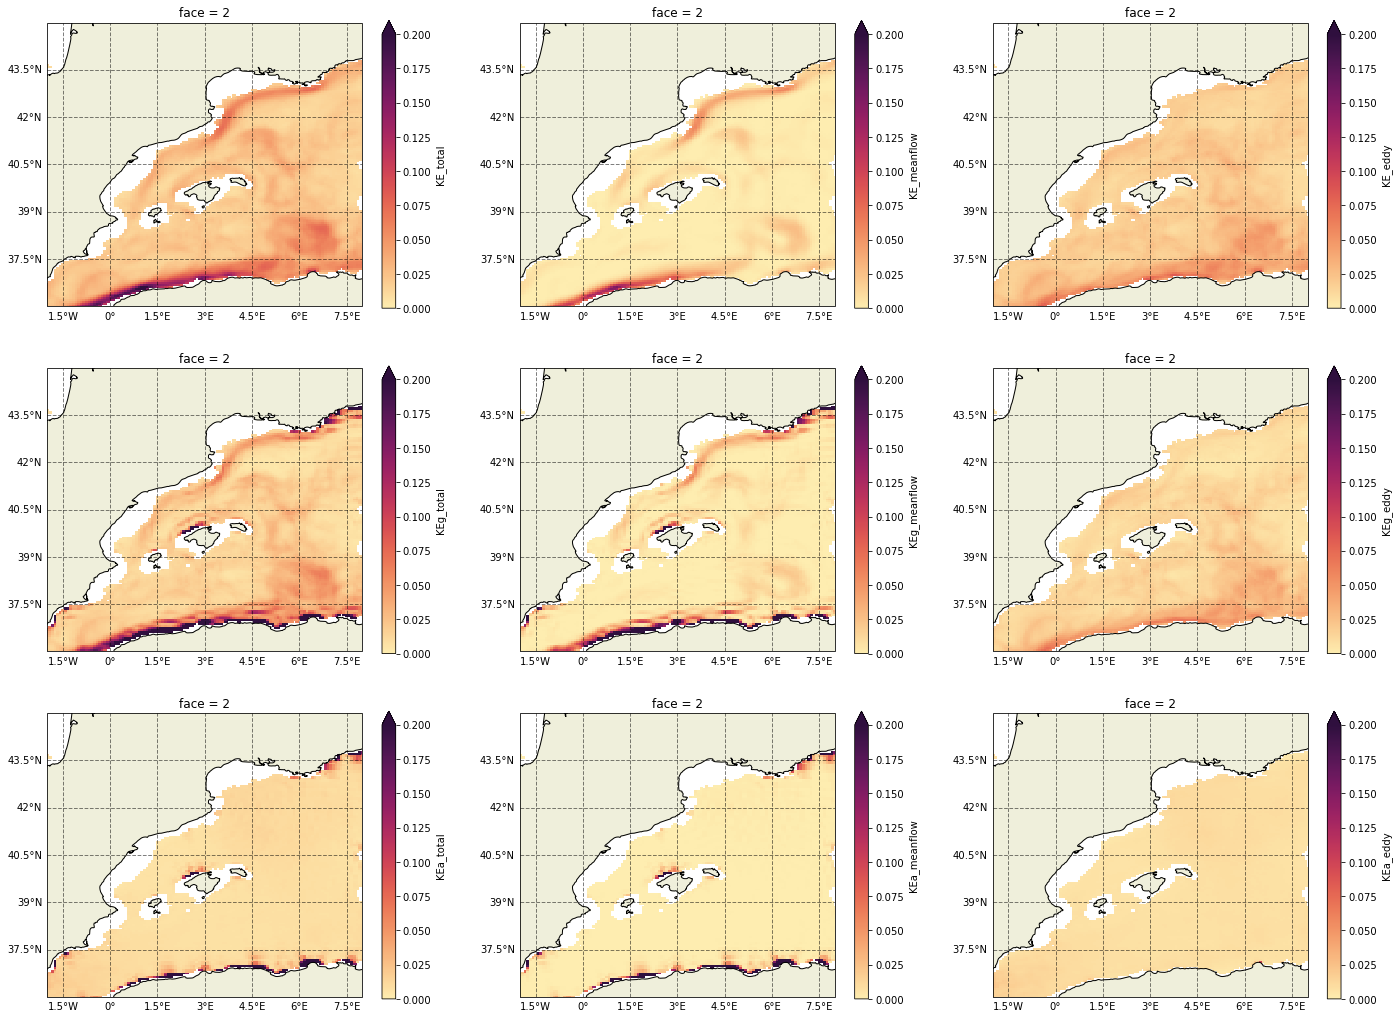

In [46]:
vmin = 0
vmax = 0.2
depth = 500

fig = plt.figure(figsize=(24,18))

# KE
ax = fig.add_subplot(331, projection=ccrs.PlateCarree())
KE.KE_total.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.)
ax.set_ylim(36., 45.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    
#ax.set_title('KE')

ax = fig.add_subplot(332, projection=ccrs.PlateCarree())
KE.KE_meanflow.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.)
ax.set_ylim(36., 45.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(333, projection=ccrs.PlateCarree())
KE.KE_eddy.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.)
ax.set_ylim(36., 45.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)  

# KEg
ax = fig.add_subplot(334, projection=ccrs.PlateCarree())
KE.KEg_total.where(KE.Depth>depth).where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.)
ax.set_ylim(36., 45.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(335, projection=ccrs.PlateCarree())
KE.KEg_meanflow.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.)
ax.set_ylim(36., 45.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(336, projection=ccrs.PlateCarree())
KE.KEg_eddy.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.)
ax.set_ylim(36., 45.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)  

# KEa
ax = fig.add_subplot(337, projection=ccrs.PlateCarree())
KE.KEa_total.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.)
ax.set_ylim(36., 45.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(338, projection=ccrs.PlateCarree())
KE.KEa_meanflow.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.)
ax.set_ylim(36., 45.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(339, projection=ccrs.PlateCarree())
KE.KEa_eddy.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-2., 8.)
ax.set_ylim(36., 45.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)  

plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KE_face02.png',dpi=300)

In [47]:
KE_total = xr.open_zarr(E_dir+'KE_total_f10.zarr')
KEg_total = xr.open_zarr(E_dir+'KEg_total_f10.zarr')
KEa_total = xr.open_zarr(E_dir+'KEa_total_f10.zarr')
KE = xr.merge([KE_total,KEg_total,KEa_total])

/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/

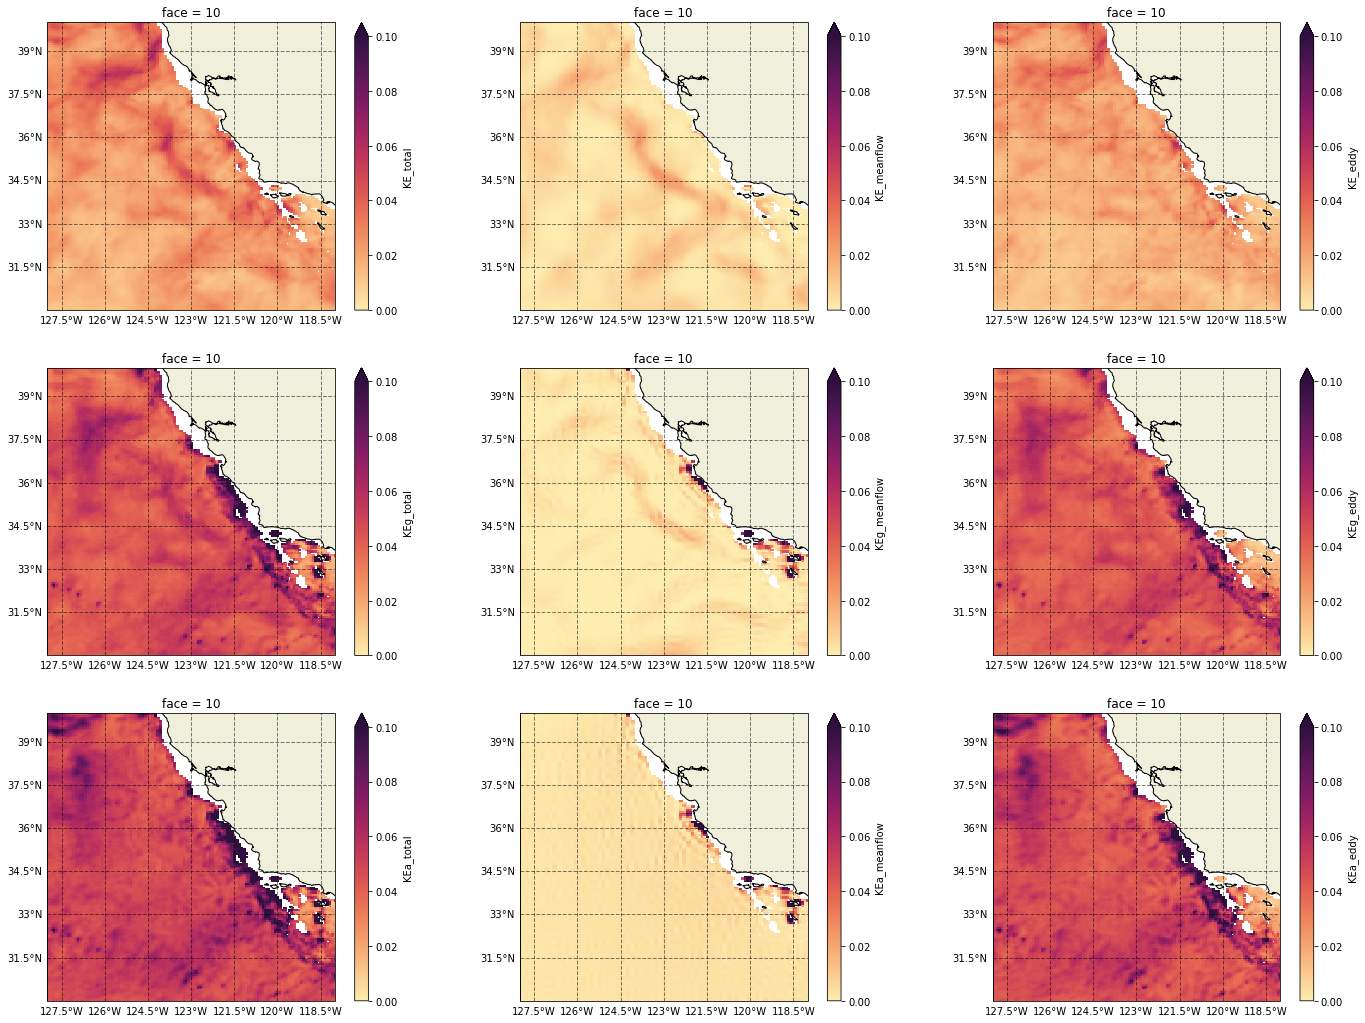

In [48]:
vmin = 0
vmax = 0.1
depth = 500

fig = plt.figure(figsize=(24,18))

# KE
ax = fig.add_subplot(331, projection=ccrs.PlateCarree())
KE.KE_total.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-128., -118.)
ax.set_ylim(30., 40.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(332, projection=ccrs.PlateCarree())
KE.KE_meanflow.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-128., -118.)
ax.set_ylim(30., 40.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(333, projection=ccrs.PlateCarree())
KE.KE_eddy.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-128., -118.)
ax.set_ylim(30., 40.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)  

# KEg
ax = fig.add_subplot(334, projection=ccrs.PlateCarree())
KE.KEg_total.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-128., -118.)
ax.set_ylim(30., 40.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(335, projection=ccrs.PlateCarree())
KE.KEg_meanflow.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-128., -118.)
ax.set_ylim(30., 40.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(336, projection=ccrs.PlateCarree())
KE.KEg_eddy.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-128., -118.)
ax.set_ylim(30., 40.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)  

# KEa
ax = fig.add_subplot(337, projection=ccrs.PlateCarree())
KE.KEa_total.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-128., -118.)
ax.set_ylim(30., 40.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(338, projection=ccrs.PlateCarree())
KE.KEa_meanflow.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-128., -118.)
ax.set_ylim(30., 40.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)    

ax = fig.add_subplot(339, projection=ccrs.PlateCarree())
KE.KEa_eddy.where(KE.Depth>depth).plot(x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cm.matter)
ax.set_xlim(-128., -118.)
ax.set_ylim(30., 40.)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='10m', color='k')
ax.add_feature(cfeature.LAND)  

plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/CalVal/KE_face10.png',dpi=300)

In [23]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
